In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
ENVIRONMENT = 'local'

if ENVIRONMENT == 'local':
    BASE_PATH = './'
elif ENVIRONMENT == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')
    
    BASE_PATH = '/content/drive/My Drive/ECE 461P Project/'
elif ENVIRONMENT == 'kaggle':
    import os
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
    # TODO: Extract and set BASE_PATH

train_df = pd.read_csv(f'{BASE_PATH}/train.tsv', sep='\t', index_col='train_id')
test_df = pd.read_csv(f'{BASE_PATH}/test.tsv', sep='\t', index_col='test_id')
# test2_df = pd.read_csv(f'{BASE_PATH}/test_stg2.tsv', sep='\t', index_col='test_id')

In [3]:
train_df

,name,item_condition_id,category_name,brand_name,price,shipping,item_description
train_id,,,,,,,
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity
...,...,...,...,...,...,...,...
1482530,Free People Inspired Dress,2,Women/Dresses/Mid-Calf,Free People,20.0,1,"Lace, says size small but fits medium perfectl..."
1482531,Little mermaid handmade dress,2,Kids/Girls 2T-5T/Dresses,Disney,14.0,0,Little mermaid handmade dress never worn size 2t
1482532,21 day fix containers and eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,NaN,12.0,0,"Used once or twice, still in great shape."


In [4]:
train_df.info()
# name is not unique
# item_condition_id is {1, 2, 3, 4, 5}, where 1 is probably new and 5 is probably poor (see https://www.mercari.com/us/help_center/product-info/item-conditions/)
# category_name can be null (likely missing) or three increasingly specific categories (e.g. Women/Women's handbags/Backpacks); some category names have slashes in their name (e.g. iPad/tablet/ebook readers), but we might assume that this can only happen in the last category
# brand_name can be null or a brand listed on the website
# price is in USD and is the target we want to predict
# shipping is 1 if paid by seller, 0 if paid by buyer
# item_description can be null, have "No description yet", or be user specified; prices in description were replaced by "[rm]"

<class 'pandas.core.frame.DataFrame'>
Index: 1482535 entries, 0 to 1482534
Data columns (total 7 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   name               1482535 non-null  object 
 1   item_condition_id  1482535 non-null  int64  
 2   category_name      1476208 non-null  object 
 3   brand_name         849853 non-null   object 
 4   price              1482535 non-null  float64
 5   shipping           1482535 non-null  int64  
 6   item_description   1482529 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 90.5+ MB


count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

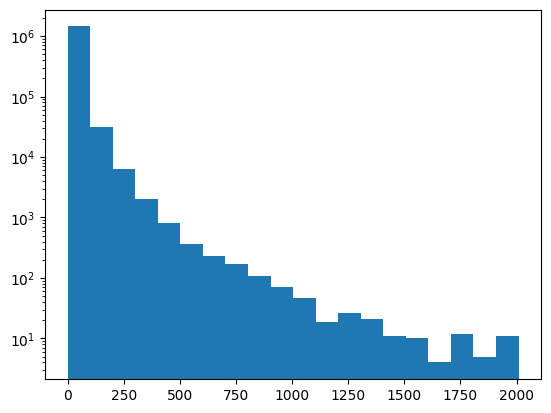

In [5]:
# Price skews right, so we might transform it to be more normal
plt.hist(train_df['price'], bins=20, log=True)
train_df['price'].describe()

In [6]:
# Strangely, some items are listed with a price of 0 USD
train_df[train_df['price'] == 0]

,name,item_condition_id,category_name,brand_name,price,shipping,item_description
train_id,,,,,,,
1325,Alabama Crimson Tide Quality Lanyard,1,Sports & Outdoors/Fan Shop/NCAA,NaN,0.0,1,TOP QUALITY THICK LANYARD Reversible sides wit...
2544,Levi leggings,3,"Women/Jeans/Slim, Skinny",Levi's®,0.0,0,Light wash. Hardly worn. Size 24 but fits like...
2712,Simple Red Lace Lingerie Top,3,Women/Underwear/G-Strings & Thongs,NaN,0.0,0,"Very simple but cute, a little form fitting as..."
3576,Turquoise 15 Pc Makeup Brush Set,1,Beauty/Tools & Accessories/Makeup Brushes & Tools,NaN,0.0,1,1 left!
3761,Girls size 7/8,3,Kids/Girls (4+)/Tops & T-Shirts,NaN,0.0,1,5 pair gap jean excellent used condition 3 chi...
...,...,...,...,...,...,...,...
1474172,Homecoming or Dama ivory dress,2,"Women/Dresses/Above Knee, Mini",NaN,0.0,0,Ivory formal dress. I wore this dress once for...
1474198,Tie up flannel top,3,Women/Tops & Blouses/Blouse,NaN,0.0,1,I got this last year and just didnt wear it mu...
1477958,Rae Dunn Measuring Pear,3,Home/Home Décor/Home Décor Accents,NaN,0.0,0,The dash lid appears it was dropped and a piec...


Bundle 2232 34.62275379144398
Reserved 453 39.31726243469863
Converse 445 8.93785554068539
BUNDLE 418 40.73660381368858
Dress 410 12.584195779698845
Coach purse 404 19.9839830958423
Lularoe TC leggings 396 11.648930570195231
Romper 353 6.250561396367981
Nike 340 16.975025290181176
Vans 334 9.939706023805332
American Eagle Jeans 325 8.244153011643599
Miss Me Jeans 284 12.928838593112092
Lularoe OS leggings 281 9.200133174695361
ON HOLD 274 45.127049274108344
Coach Purse 258 21.172202964856144


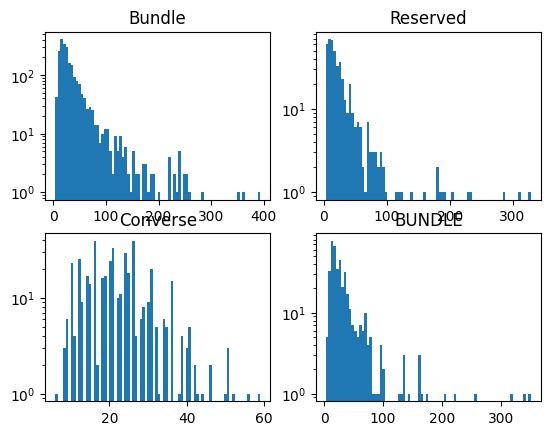

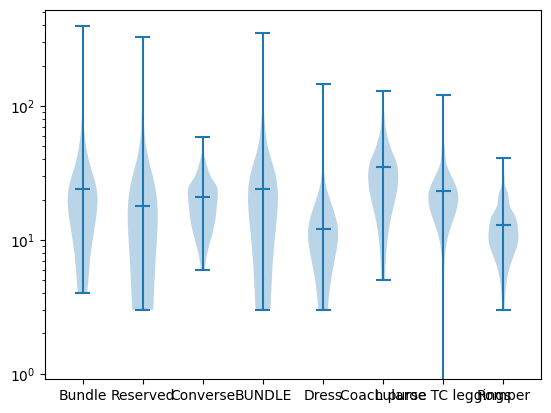

In [7]:
names = train_df['name'].value_counts()
# Many product listings have the same name, so we can check for prices
# A good amount of these "generic names" have high range / standard deviation in price

# Standard deviation
top_n = 15
for i in range(top_n):
    name = names.index[i]
    filtered_data = train_df[train_df['name'] == name]
    print(name, names.iat[i], filtered_data['price'].std())

# Histogram
rows = 2
cols = 2
fig, axs = plt.subplots(rows, cols)
for r in range(rows):
    for c in range(cols):
        name = names.index[r * cols + c]
        axs[r, c].set_title(name)
        axs[r, c].hist(train_df[train_df['name'] == name]['price'], bins=80, log=True)

# Violin
top_n = 8
prices_by_name = []
name_list = []
for i in range(top_n):
    name = names.index[i]
    filtered_data = train_df[train_df['name'] == name]
    prices_by_name.append(filtered_data['price'])
    name_list.append(name)

fig, ax = plt.subplots()
ax.violinplot(prices_by_name, showmedians=True)
ax.set_xticks(np.linspace(1, top_n, top_n), labels=name_list)
ax.set_yscale('log')


item_condition_id
1    640549
3    432161
2    375479
4     31962
5      2384
Name: count, dtype: int64



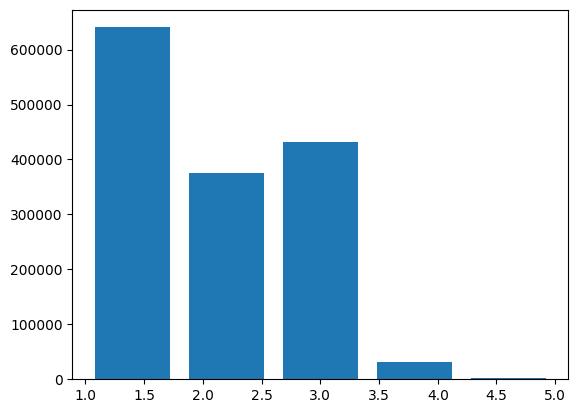

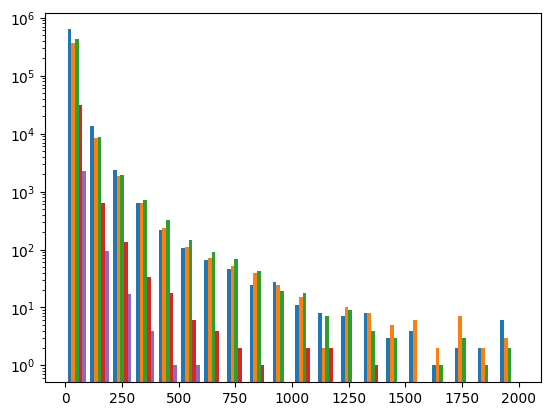

In [8]:
# Distribution of item condition
print(train_df['item_condition_id'].value_counts())
fig, ax = plt.subplots()
ax.hist(train_df['item_condition_id'], bins=5, rwidth=0.8)

# Histogram by item condition
item_condition_data = train_df.groupby(by='item_condition_id')
item_condition_partition = []
for i in item_condition_data.groups:
    item_condition_partition.append(item_condition_data.get_group(i)['price'])

fig, ax = plt.subplots()
ax.hist(item_condition_partition, bins=20, log=True)
print()

In [9]:
# A "null" category is probably a missing value (i.e. should match an existing category)
train_df[train_df['category_name'].isnull()]

,name,item_condition_id,category_name,brand_name,price,shipping,item_description
train_id,,,,,,,
122,Bundle,3,NaN,NaN,59.0,0,Sizes and info of clothes can be found on thei...
155,3 Nora Roberts Books,3,NaN,NaN,10.0,1,For aferg16.
258,ACER Laptop,5,NaN,NaN,14.0,0,"Powers on, no screen display, no external dama..."
984,AUTHENTIC BRWN MICHAEL KORS MAKEUP STAIN,4,NaN,Michael Kors,18.0,0,No description yet
1185,Teenage Mutant Ninja Turtle Van/ Extras,3,NaN,Nickelodeon,9.0,0,"Teenage Mutant Ninja Turtle Van, April O'Neil ..."
...,...,...,...,...,...,...,...
1481249,Only For Erin. Do Not Buy,3,NaN,NaN,31.0,0,No description yet
1481750,American Eagle Jeggings,2,NaN,American Eagle,17.0,0,Worn a couple of time Size 4
1482252,Bundle For All Honey :),3,NaN,NaN,40.0,0,No description yet


In [10]:
# Split category_name into three parts
category_splits = train_df['category_name'].str.split('/', n=2, expand=True)
category_splits.head(10)

,0,1,2
train_id,,,
0,Men,Tops,T-shirts
1,Electronics,Computers & Tablets,Components & Parts
2,Women,Tops & Blouses,Blouse
3,Home,Home Décor,Home Décor Accents
4,Women,Jewelry,Necklaces
5,Women,Other,Other
6,Women,Swimwear,Two-Piece
7,Sports & Outdoors,Apparel,Girls
8,Sports & Outdoors,Apparel,Girls


In [11]:
category_splits.value_counts(sort=False)

0       1                 2                       
Beauty  Bath & Body       Bath                         5049
                          Bathing Accessories           332
                          Cleansers                     723
                          Other                         147
                          Scrubs & Body Treatments      812
                                                      ...  
Women   Women's Handbags  Messenger & Crossbody        8926
                          Other                        1116
                          Satchel                      2333
                          Shoulder Bag                15328
                          Totes & Shoppers             9373
Name: count, Length: 1287, dtype: int64

In [12]:
# Brand name is inherently categorical but can be null
print('brand_name is not null:')
print(train_df['brand_name'].value_counts())
print()
print('brand_name is null:')
print(train_df['brand_name'].isnull().value_counts())

brand_name is not null:
brand_name
PINK                    54088
Nike                    54043
Victoria's Secret       48036
LuLaRoe                 31024
Apple                   17322
                        ...  
The Learning Journey        1
Pampers Baby Fresh          1
Huggies One & Done          1
Classic Media               1
Kids Only                   1
Name: count, Length: 4809, dtype: int64

brand_name is null:
brand_name
False    849853
True     632682
Name: count, dtype: int64


             count       mean       std  min   25%   50%   75%     max
shipping                                                              
0         819435.0  30.111778  39.53592  0.0  13.0  20.0  33.0  2009.0
1         663100.0  22.567726  36.95579  0.0   8.0  14.0  25.0  2000.0



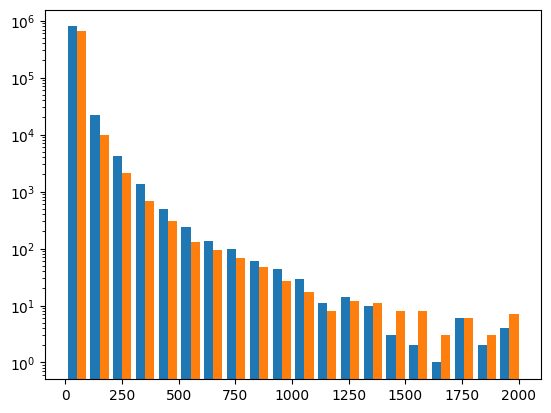

In [13]:
# Distribution of shipping (0=buyer, 1=seller)
shipping_data = train_df.groupby(by='shipping')
print(shipping_data['price'].describe())

shipping_partition = []
for i in shipping_data.groups:
    shipping_partition.append(shipping_data.get_group(i)['price'])

plt.hist(shipping_partition, bins=20, log=True)
print()

In [14]:
# Some item descriptions are repeated
description_data = train_df['item_description']

# Some items are missing a description
print('Item description is null:')
print(description_data.isnull().value_counts())
print()

# By far, the most common "description" is "No description yet"
# Other most common descriptions are just generic descriptions
description_rank = description_data.value_counts()
description_rank.head(20)


Item description is null:
item_description
False    1482529
True           6
Name: count, dtype: int64



item_description
No description yet     82489
New                     4099
Brand new               3058
Good condition          1274
Great condition         1158
Like new                 987
Never worn               837
NWT                      822
New with tags            644
Never used               605
Excellent condition      604
Worn once                582
Brand new with tags      518
Size small               453
Brand new!               447
New in box               442
BNWT                     435
Brand New                424
Bundle                   401
Brand new.               389
Name: count, dtype: int64

In [15]:
# Some items mention a price in the description. They have been replaced by "[rm]"
rm_price_desc = train_df['item_description'].str.contains('[rm]', na=False, regex=False)
print(rm_price_desc.value_counts())

rm_price_desc = train_df[rm_price_desc]
rm_price_desc.head(10)

item_description
False    1348729
True      133806
Name: count, dtype: int64


,name,item_condition_id,category_name,brand_name,price,shipping,item_description
train_id,,,,,,,
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
7,Girls cheer and tumbling bundle of 7,3,Sports & Outdoors/Apparel/Girls,Soffe,6.0,1,You get three pairs of Sophie cheer shorts siz...
10,Smashbox primer,2,Beauty/Makeup/Face,Smashbox,8.0,1,0.25 oz Full size is 1oz for [rm] in Sephora
17,New: Baby K'tan active baby carrier,1,Kids/Gear/Backpacks & Carriers,NaN,29.0,1,Brand new in box Size: Medium Color: Coral Ret...
23,Triple car charger,1,Electronics/Cell Phones & Accessories/Chargers...,NaN,8.0,1,Brand new never used All colors are available ...
30,Too Faced Better Than Sex Mascara QTY3,1,Beauty/Makeup/Eyes,Too Faced,32.0,1,BNIB 3 for [rm] Better Than Sex Waterproof Mas...
67,H&M Women's Long Horse Sweater,2,Women/Sweaters/Crewneck,H&M,16.0,0,"-size XS (fits long), or S (fits medium length..."
72,Listing for Aknuckles1,1,Home/Home Décor/Home Fragrance,Nostalgia Electrics,35.0,0,WARMERS PICTURED & 6 SAMPLE PACKAGES OF HIGHLY...
103,kids adidas,1,Kids/Boys 2T-5T/Shoes,NaN,36.0,0,size 13 Kids brand new. paid [rm] FIRM ON THE ...
